In [3]:
%matplotlib qt
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
import imageio.v3 as iio
import math
import skimage.transform as sktr

Part 1.1: Convolutions from Scratch using numpy only

In [7]:
# processing my picture by reading it in grayscale
im = Image.open('media/self.jpg').convert('L')
im.save('greyscale.jpg')
img = np.array(im, dtype=np.float32) / 255   

plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.axis("off");
plt.show()

In [8]:
# implementing convolution with padding using 4 for loops then 2 for loops
# padding means to add a border of zeros around the original input matirx, creating a larger matrix. padded amount determines the size of border
def padding(img,shape):
    h,w=shape
    padh,padw = h//2,w//2
    return np.pad(img,((padh,padh),(padw,padw)),mode="constant",constant_values=0)

# rmb to compare with built-in convolution function writeup for website

In [1]:
def convolution4loops(img,kernel): #kernel is the filter
    img = img.astype(np.float32)
    kernel = np.flipud(np.fliplr(kernel.astype(np.float32)))
    kh,kw=kernel.shape #aka 9x9 box
    h,w=img.shape
    pad = padding(img,(kh,kw))
    output = np.zeros_like(img,dtype=np.float32)

    for y in range(h):
        for x in range(w):
            pic = 0
            for i in range(kh):
                for j in range(kw):
                    pic += pad[y+i,x+j]*kernel[i,j]
            output[y,x] = pic
    return output

def convolution2loops(img,kernel):
    img = img.astype(np.float32)
    kernel = np.flipud(np.fliplr(kernel.astype(np.float32)))
    kh,kw=kernel.shape #aka 9x9 box
    h,w=img.shape
    pad = padding(img,(kh,kw))
    output = np.zeros_like(img,dtype=np.float32)
    min = pad

    for i in range(kh):
        for j in range(kw):
            slider = min[i:i+h,j:j+w]
            output += slider *kernel[i,j]
    return output


In [4]:
# creating 9x9 filter and greyscale selfie
filterBox = np.ones((9,9),np.float32)/(9*9)
dx = np.array([[1,0,-1]],np.float32)
dy = np.array([[1],[0],[-1]],np.float32)

In [10]:
#running convolutions 
fourloops=convolution4loops(img,filterBox)
twoloops=convolution2loops(img,filterBox)
plt.imshow(fourloops, cmap='gray', vmin=0, vmax=1)
plt.title('Box filter convolutions with 4 loops');
plt.axis("off");
plt.show()

plt.imshow(twoloops, cmap='gray', vmin=0, vmax=1)
plt.title('Box filter convolutions with 2 loops');
plt.axis("off");
plt.show()

Part 1.2: Finite Difference Operator

In [11]:
cameraman="media/cameraman.png"
im = iio.imread(cameraman).astype(np.float32)
if im.ndim == 3:                     
    im = im[..., :3]                
    img = 0.299*im[...,0] + 0.587*im[...,1] + 0.114*im[...,2]
else:
    img = im
if img.max() > 1:
    img /= 255.0

plt.imshow(img, cmap="gray", vmin=0, vmax=1)
plt.axis("off");
plt.show()

Partial Derivatives

In [ ]:
Ix = convolve2d(img, dx, mode="same",boundary="symm")
Iy = convolve2d(img, dy, mode="same",boundary="symm") #need to put same mode otherwise not equal, cannot form gradient magnitude image
v = np.max([np.abs(Ix).max(), np.abs(Iy).max()]) #coz want grey plots

plt.figure(figsize=(8,8))
plt.subplot(1,2,1); plt.imshow(Ix,cmap="gray", vmin=-v, vmax=v); plt.title("Partial Derivative dI/dx");
plt.axis("off"); 
plt.subplot(1,2,2); plt.imshow(Iy,cmap="gray", vmin=-v, vmax=v); plt.title("Partial Derivative dI/dy");
plt.axis("off");
plt.show()

2025-09-26 18:23:37.962 python[23951:744050] +[CATransaction synchronize] called within transaction


Gradient Magnitude Image

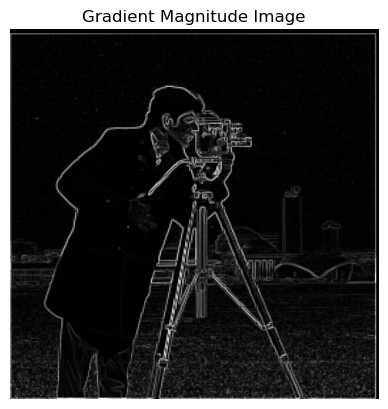

In [11]:
gradMag = np.sqrt(Ix**2 + Iy**2)
plt.imshow(gradMag, cmap="gray"); 
plt.title("Gradient Magnitude Image"); 
plt.axis("off");
plt.show()

Binarise gradient magnitude image by picking appropriate threshold (tradeoff noise and edges) to turn into edge image

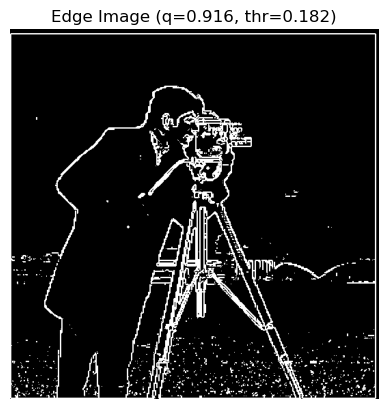

In [12]:
k = 0.916                  #can still see outline of background but reduced noise
threshold = np.quantile(gradMag, k)
edges = (gradMag >= threshold).astype(np.float32)

plt.imshow(edges, cmap="gray", vmin=0, vmax=1); 
plt.title(f"Edge Image (q={k}, thr={threshold:.3f})");
plt.axis("off");
plt.show()

Derivative of Gaussian (DoG) Filter

In [20]:
#convolving with a gaussian 
#without opencv module:

def gaussian1d(sigma, ksize=None):
    if ksize is None:
        ksize = int(np.ceil(6*sigma)) | 1
    if ksize % 2 == 0:
        ksize += 1
    r = ksize // 2
    x = np.arange(-r, r+1, dtype=np.float32)
    g = np.exp(-(x**2) / (2*sigma**2))
    g /= g.sum()
    return g

def gaussian2d(sigma, ksize=None):
    g1 = gaussian1d(sigma, ksize)
    G = np.outer(g1, g1).astype(np.float32)
    G /= G.sum()
    return G
sigma = 1.2
G = gaussian2d(sigma) 

gaussianImg=convolve2d(img,G,mode="same",boundary="symm") #convolving original image with gaussian

gIx=convolve2d(gaussianImg,dx,mode="same",boundary="symm")
gIy=convolve2d(gaussianImg,dy,mode="same",boundary="symm")
gaussianGradMag = np.sqrt(gIx**2 + gIy**2) #blurring image first

plt.imshow(gaussianImg, cmap="gray", vmin=0, vmax=1); 
plt.title("Original Image with Gaussian Blur")
plt.axis("off");
plt.show()
plt.imshow(gaussianGradMag, cmap="gray", vmin=0, vmax=1); 
plt.title("Gradient Magnitude with Gaussian Blur")
plt.axis("off");
plt.show() #noticed alot of the noise on the ground is gone, and lines are fainter but more evenly thick as well, smoother

In [133]:
k = 0.916                   
threshold = np.quantile(gaussianGradMag, k)
edges = (gaussianGradMag >= threshold).astype(np.float32)

plt.imshow(edges, cmap="gray", vmin=0, vmax=1); 
plt.title(f"Gaussian Edge Image (q={k}, thr={threshold:.3f})");
plt.axis("off");
plt.show() #noticed its easier to achieve the balance between clear edges and less nosie


2025-09-26 11:47:41.899 python[3866:24484] +[CATransaction synchronize] called within transaction


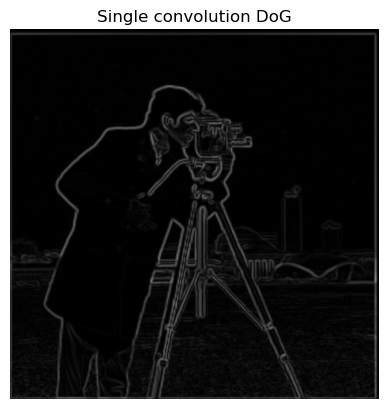

In [15]:
#single convolution instead of 2 using derivatives of gaussian filters
# convolving gaussian with dx and dy:
dogX = convolve2d(G, dx, mode="full")  
dogY = convolve2d(G, dy, mode="full")  

dogIx = convolve2d(img, dogX, mode="same", boundary="symm")
dogIy = convolve2d(img, dogY, mode="same", boundary="symm")
dogGradMag = np.sqrt(dogIx**2 +dogIy**2)

plt.imshow(dogGradMag, cmap="gray", vmin=0, vmax=1); 
plt.title("Single convolution DoG")
plt.axis("off");
plt.show() #yes they look the same

In [134]:
k = 0.916                   
threshold = np.quantile(dogGradMag, k)
edges = (dogGradMag >= threshold).astype(np.float32)

plt.imshow(edges, cmap="gray", vmin=0, vmax=1); 
plt.title(f"DoG Edge Image (q={k}, thr={threshold:.3f})");
plt.axis("off");
plt.show()

2025-09-26 11:48:13.670 python[3866:24484] +[CATransaction synchronize] called within transaction


Yes results are the same, and is better than that without Gaussian blur. Images have less noise while retaining sharp edge details.

Part 2.1: Image "Sharpening"

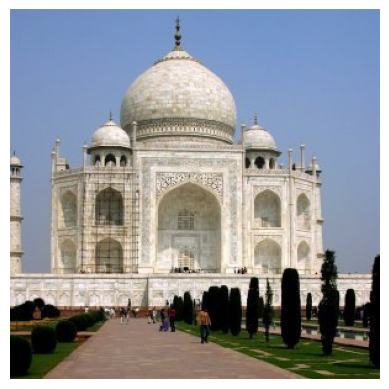

In [17]:
blurry="media/blur.jpg"
im = iio.imread(blurry).astype(np.float32)
im /= 255 #to prevent clipping everythinig to white
plt.imshow(im)
plt.axis("off");
plt.show()

In [18]:
#to sharpen image, low-pass filter and enhance the high frequency details

def unsharp_mask(image,sigma=1.2,amount=1):
    G = gaussian2d(sigma)
    k=amount
    delta=np.zeros_like(G,dtype=np.float32)
    gy,gx=G.shape[0]//2,G.shape[1]//2 #tuple assigning
    delta[gy,gx]=1

    unsharp = (1+k)*delta-k*G
    
    output=np.empty_like(image)
    for n in range(image.shape[2]):
        output[...,n] = convolve2d(image[...,n],unsharp,mode="same")
    return np.clip(output,0,1),unsharp

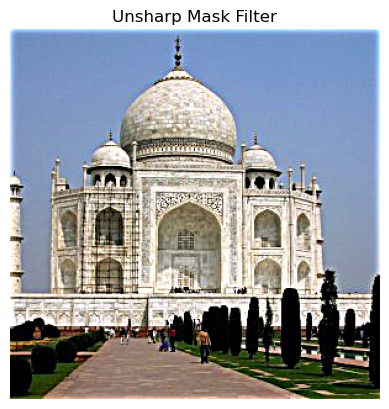

In [19]:
sharp, unsharp = unsharp_mask(im, sigma=2.4, amount=1.4) #sigma and amount can be adjusted
plt.imshow(sharp); 
plt.title("Unsharp Mask Filter"); 
plt.axis("off");
plt.show()

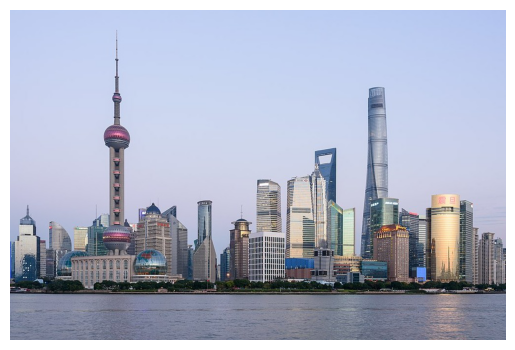

In [20]:
#original sharp image
clear="media/skyline.jpg"
clearimg = iio.imread(clear).astype(np.float32)
clearimg /= 255
plt.imshow(clearimg)
plt.axis("off");
plt.show()

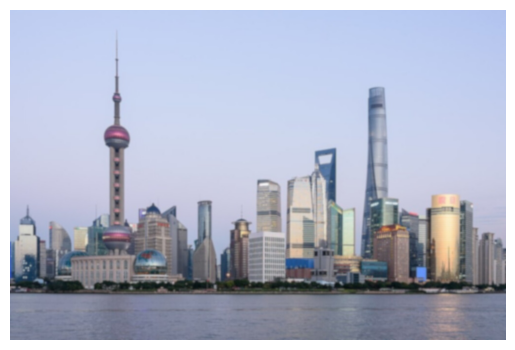

In [21]:
#manually blurred image that we will attempt to reconstruct
blur2="media/blur2.png"
blurimg = iio.imread(blur2).astype(np.float32)
blurimg /= 255
plt.imshow(blurimg)
plt.axis("off");
plt.show()

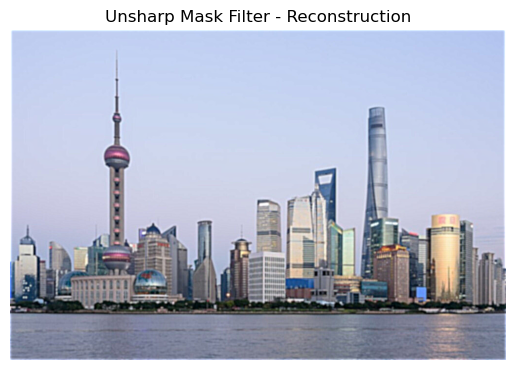

In [22]:
sharp2, unsharp = unsharp_mask(blurimg, sigma=2.5, amount=1.5) #sigma and amount can be adjusted
plt.imshow(sharp2); 
plt.title("Unsharp Mask Filter - Reconstruction"); 
plt.axis("off");
plt.show() 
#windows/lines on buildings are more well-defined and most prominent changes.
#resoltuion is much worse because it inherits the poor resolution from the blur. not all details present but lines are more defined

Part 2.2: Hybrid Images

In [25]:
#conrad further away => hes low pass filter
#jeremiah closer => hes high pass filter
conrad="media/nutmeg.jpg"
connie = iio.imread(conrad).astype(np.float32)
connie /= 255

jeremiah="media/DerekPicture.jpg"
jere = iio.imread(jeremiah).astype(np.float32)
jere /= 255

In [15]:
from align_image_code import align_images

In [16]:

def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale,channel_axis=-1,anti_aliasing=True)
    else:
        im2 = sktr.rescale(im2, 1./dscale,channel_axis=-1,anti_aliasing=True)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2


if __name__ == "__main__":
    # 1. load the image
    # 2. align the two images by calling align_images
    # Now you are ready to write your own code for creating hybrid images!
    pass


In [28]:
conaligned,jeraligned=align_images(connie,jere)

Please select 2 points in each image for alignment.


In [29]:
def grayscale(img):
    if img.ndim == 3 and img.shape[2] == 3:   # RGB
        img = img.astype(np.float32)
        if img.max() > 1.5:  # uint8
            img = img / 255.0
        # luminance weights
        r, g, b = img[...,0], img[...,1], img[...,2]
        gray = 0.2126*r + 0.7152*g + 0.0722*b
        return gray.astype(np.float32)
    elif img.ndim == 2:  # already gray
        img = img.astype(np.float32)
        if img.max() > 1.5:
            img = img / 255.0
        return img
    else:
        raise ValueError("Unsupported image shape")

#making grayscale so 2 channeles can be supported by 2D gaussian function
conaligned_gray = grayscale(conaligned)
jeraligned_gray = grayscale(jeraligned)


In [30]:
sigma_low  = 5.0   # adjust for low-pass on conaligned
sigma_high = 5.0   # adjust for high-pass on jeraligned
alpha, beta = 0.5, 0.5  # weights for combining, im just taking average

G_low  = gaussian2d(sigma_low)
G_high = gaussian2d(sigma_high)

con_low  = convolve2d(conaligned_gray, G_low, mode="same", boundary="symm")
jere_blur = convolve2d(jeraligned_gray, G_high, mode="same", boundary="symm")
jere_high = jeraligned_gray - jere_blur

hybrid = alpha * con_low + beta * jere_high
# normalise to [0,1] for display
hybrid = (hybrid - hybrid.min()) / (hybrid.max() - hybrid.min() + 1e-8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(con_low, cmap="gray");  plt.title("Low-pass Nutmeg"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(jere_high, cmap="gray"); plt.title("High-pass Derek"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(hybrid, cmap="gray");   plt.title("Hybrid Image"); plt.axis("off")
plt.show()

2025-09-26 19:01:26.694 python[23951:744050] +[CATransaction synchronize] called within transaction
2025-09-26 19:01:29.945 python[23951:744050] +[CATransaction synchronize] called within transaction
2025-09-26 19:01:33.028 python[23951:744050] +[CATransaction synchronize] called within transaction


In [32]:
plt.imshow(hybrid, cmap="gray");
plt.axis("off")
plt.show()

Frequency Analysis Plot

In [ ]:
def fft_log_mag(img):#logmagnitude
    F = np.fft.fft2(img)
    Fshift = np.fft.fftshift(F)
    mag = np.log(np.abs(Fshift) + 1e-8)  # add epsilon to avoid log(0)
    return mag

In [ ]:
fft_conaligned = fft_log_mag(conaligned_gray)
fft_jeraligned = fft_log_mag(jeraligned_gray)
fft_con_low = fft_log_mag(con_low)
fft_jere_high = fft_log_mag(jere_high)
fft_hybrid = fft_log_mag(hybrid)

plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.imshow(fft_conaligned, cmap='gray')
plt.title("FFT Manon (input)"); plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(fft_jeraligned, cmap='gray')
plt.title("FFT Robert (input)"); plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(fft_con_low, cmap='gray')
plt.title("FFT Low-pass Manon"); plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(fft_jere_high, cmap='gray')
plt.title("FFT High-pass Robert"); plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(fft_hybrid, cmap='gray')
plt.title("FFT Hybrid"); plt.axis("off")

plt.tight_layout()
plt.show()